In [23]:
### Illustration du biais de regularisation
### Denrière modification: 04/03/2020
### Jérémy L'Hour


rm(list=ls())

##############################
##############################
### PACKAGES AND FUNCTIONS ###
##############################
##############################

#install.packages("gridExtra")
library("MASS")
library("glmnet")
library("ggplot2")
library("gridExtra")

### FONCTIONS
source("functions/DataSim.R") 

# POST-LASSO
PostLasso <- function(X,y,nopen){
    #'@param nopen indices des variables a ne pas penaliser
    phi = rep(1,ncol(X)); phi[nopen] = 0
    # ETAPE 1
    cv.lasso = cv.glmnet(X,y, family="gaussian",alpha=1,penalty.factor=phi,nfolds=5)
    b.lasso = coef(cv.lasso); b.lasso = b.lasso[-1] # on enleve la constante
    s.hat = which(b.lasso != 0) # indices des variables actives parmi les X
    # ETAPE 2
    postlasso = lm(y ~ X[,s.hat])
    
    return(coef(postlasso))
}

# POST-STUDENT
PostStudent <- function(X,y,nopen,alpha=.5){
    #'@param nopen indices des variables a ne pas penaliser
    #'@param alpha niveau de significativite pour selection
    # ETAPE 1
    fullreg = lm(y ~ X)
    s.hat = summary(fullreg)$coef[,"Pr(>|t|)"] < alpha
    s.hat = which(s.hat[-1] == T)
    s.hat = union(nopen,s.hat)
    # ETAPE 2
    shortreg = lm(y ~ X[,s.hat])

    return(coef(shortreg))
}

In [24]:
######################
######################
### 1. SIMULATIONS ### 
######################
######################

R = 2000 # nb simulations
n = 200 # sample size
p = 30 # nb variables
tau = .5 # vraie valeur de l'effet

set.seed(999)
Results = matrix(ncol=3, nrow=R)

In [25]:
t_start = Sys.time()

for(r in 1:R){
  ### GENERATE DATA
  data = DataSim(n=n,p=p,Ry=.1,Rd=.8,Intercept=F,a=tau)
  X = cbind(data$d,data$X); y = data$y
  
  ### METHOD 1: Modele complet
  full.reg = lm(y ~ X)

  ### METHOD 2: Selection Lasso
  lasso.reg = PostLasso(X,y,nopen=c(1))
  
  ### METHOD 3: Selection sur la stat de Student
  student.reg = PostStudent(X,y,nopen=c(1),alpha=.05)
  
  ### COLLECTING RESULTS
  Results[r,] = c(full.reg$coef[2],
                  lasso.reg[2],
                  student.reg[2])
}

print(Sys.time()-t_start)

Time difference of 1.57248 mins


In [27]:
################################
################################
### 2. COMPUTE BIAS AND RMSE ###
################################
################################

StatDisplay = data.frame()
StatDisplay[1:3,"Bias"] = apply(Results-tau,2,mean)
StatDisplay[1:3,"RMSE"] = sqrt(apply((Results-tau)^2,2,mean))
row.names(StatDisplay) = c("Complet","Post-Lasso","Post-Student")
print(StatDisplay)

                    Bias      RMSE
Complet      0.004172147 0.2204123
Post-Lasso   0.343363909 0.4353365
Post-Student 0.033008144 0.2248380


Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

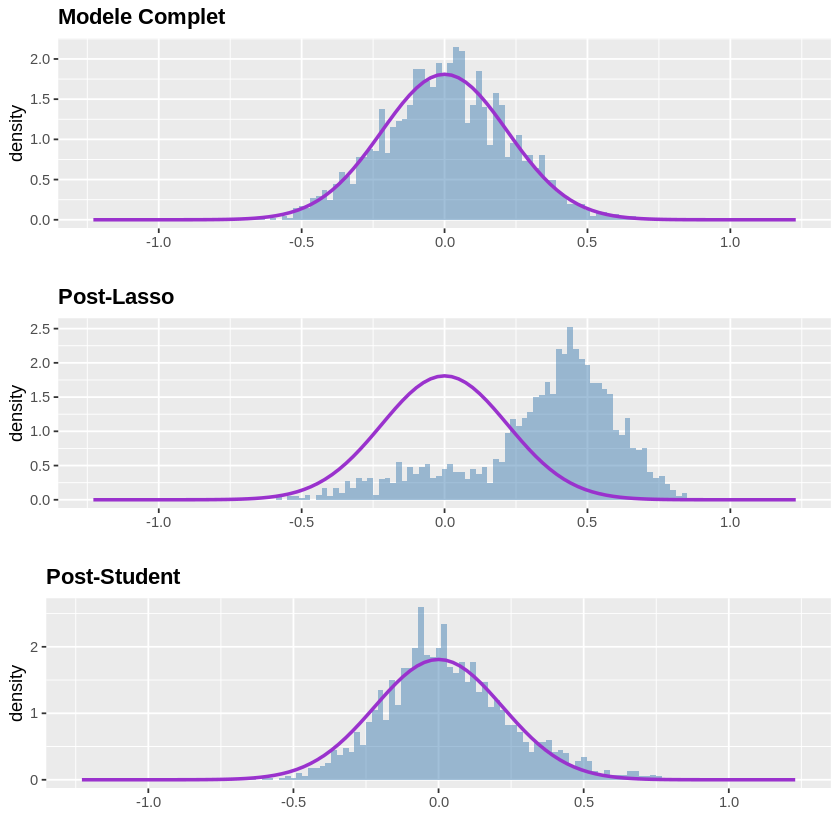

In [28]:
#######################
#######################
### 3. DRAW CHARTS ####
#######################
#######################

id = c(mapply(function(x) rep(x,R),1:3))
val = c(Results)-tau
data_res = data.frame(val = val, model = id)

M = max(abs(quantile(Results,.01,na.rm=T)),abs(quantile(Results,.99,na.rm=T)))
lb = -1*M; ub = 1*M

get.plot <- function(data,modelS,title="A Title",s){
  plot_res <- ggplot(subset(data, (model==modelS)), aes(x=val)) + 
    geom_histogram(binwidth = .02, alpha=.5, position='identity',fill="steelblue", aes(y = ..density..)) +
    scale_x_continuous(limits=c(lb,ub), name=" ") +
    ggtitle(title) + 
    stat_function(fun = dnorm, args=list(mean=0, sd=s), colour="darkorchid3", size=1) +
    theme(plot.title = element_text(lineheight=.8, face="bold"),legend.position="none")
  return(plot_res)
} # plot func


grid.arrange(get.plot(data_res,1,"Modele Complet", StatDisplay[1,2]), 
             get.plot(data_res,2,"Post-Lasso",  StatDisplay[1,2]), 
             get.plot(data_res,3,"Post-Student",  StatDisplay[1,2]), ncol=1)

In [29]:
pdf("regbiasimulations.pdf",width=14,height=4)
grid.arrange(get.plot(data_res,1,"Modele Complet", StatDisplay[1,2]), 
             get.plot(data_res,2,"Post-Lasso",  StatDisplay[1,2]), 
             get.plot(data_res,3,"Post-Student",  StatDisplay[1,2]), ncol=3)
dev.off()

Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

png 
  2